In [1]:
import os
import shapely
import numpy as np
import sys
import pycoredb
import pandas as pd
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd
import seaborn as sns


# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

def save_geometry(dataframe,geometry,out_path,fname='dataframe.geojson'):
    df_to_save = gpd.GeoDataFrame(geometry=dataframe[geometry],crs="EPSG:4326")
    df_to_save = df_to_save.to_crs("epsg:4326")
    df_to_save.to_file(os.path.join(out_path,fname),driver="GeoJSON")

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "California"
city = "SantaClara"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_012_nam_usa_uca.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_06085/Parcels_06085.shp")
building_geojson = os.path.join(data_path,state,'California.geojson')

## Read APT Data

In [4]:
# apt_df = gpd.read_file(apt_data_path)
# apt_df = gpd.GeoDataFrame(apt_df,crs="EPSG:4326",geometry='geometry')
# apt_df = apt_df.to_crs("epsg:4326")
# print("Total number of data points collected from MNR database ",apt_df.shape[0])
# gc.collect()
# apt_df.head() 

In [3]:
apt_preprocess = ProcessAPT_data(
                    parcel_shapefile=parcel_path,
                    building_shapefile=building_geojson,
                    apt_shape_file=apt_data_path,
                    output_path = os.path.join(data_path,state,city,'Apt_realignment') 
                    )

processed_df_califronia = apt_preprocess.process_dataframe(bfp_count_per_parcel=2,filename='APT_realigned_usa_uca_california')

print("Data Shape:",processed_df_califronia.shape)

2022-08-22 11:43:15,051:INFO:- Processing APT's with 2 BFP-Count Per Parcel
2022-08-22 11:43:15,052:INFO:- Processing Land Parcel data and Building Footprints 
2022-08-22 11:54:28,781:INFO:- Acquiring BFP's within land Parcels 
2022-08-22 11:54:29,338:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe


In [ ]:
processed_df_califronia.head()

In [18]:
from pyproj import Geod

# specify a named ellipsoid
geod = Geod(ellps="WGS84")

import shapely 
def prep_polygons_asarr(gs):
    def get_pts(poly):
        if isinstance(poly, shapely.geometry.Polygon):
            coords = np.array(poly.exterior.coords)
        elif isinstance(poly, shapely.geometry.MultiPolygon):
            coords = np.concatenate([get_pts(sp) for sp in poly.geoms])
        return coords
    return [get_pts(poly) for poly in gs]

def get_nearest_poly(pt, polys):
    polys = prep_polygons_asarr(polys)
    dists = np.array([np.abs(np.linalg.norm(poly - pt, axis=1)).min() for poly in polys])
    return dists.argmin()


def process_mapping(val,area_thresh=150):
    anchor_point = list(val['APT'])[0]
    building_polygons = list(val['building_roi'][:2])
    ret = {}
    for cols in req_columns:
        ret[cols] = val.iloc[0][cols]

    geo_area = list(val['building_roi'].apply(lambda poly: abs(geod.geometry_area_perimeter(poly)[0])))[:2]
    area_diff = geo_area[0] - geo_area[1]
    if area_diff > 0 :
        if area_diff > area_thresh:
            ret['building_roi']=building_polygons[0]
        else:
            ret['building_roi'] = (list(val['building_roi'][:2])[get_nearest_poly(anchor_point,building_polygons)])

    elif area_diff < 0 :
        if np.abs(area_diff)> area_thresh:
            ret['building_roi']=  building_polygons[1]
        else:
            ret['building_roi']= (list(val['building_roi'][:2])[get_nearest_poly(anchor_point, building_polygons)])
    
    return ret
    
final_output = processed_df.groupby(['PRCLDMPID'],as_index=False).apply(lambda x: pd.Series(process_mapping(x))) # transform(pd.Series.diff).apply(lambda x: process_mapping(x))
final_output.head()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,PRCLDMPID,building_roi,APT,APT_lat,APT_lon,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,geometry
0,100660192_176965927,"POLYGON ((-122.168092 37.447652, -122.168068 3...",POINT (-122.1681141 37.447704),37.447704,-122.168114,00005543-3300-2800-0000-000000649b71,Latn,ENG,94301,180,CA,Palo Alto,Palo Alto Ave,USA,None,Ave,None,None,Palo Alto,"POLYGON ((-122.16812 37.44754, -122.16825 37.4..."
1,100660192_176966047,"POLYGON ((-122.143565 37.457609, -122.143349 3...",POINT (-122.1433577 37.4575944),37.457594,-122.143358,00005543-3300-2800-0000-00000064e974,Latn,ENG,94301,87,CA,Palo Alto,Crescent Dr,USA,None,Dr,None,None,Crescent,"POLYGON ((-122.14330 37.45736, -122.14337 37.4..."
2,100660192_176966048,"POLYGON ((-122.143672 37.457632, -122.143623 3...",POINT (-122.1437016 37.4576534),37.457653,-122.143702,00005543-3300-2800-0000-00000064e972,Latn,ENG,94301,79,CA,Palo Alto,Crescent Dr,USA,None,Dr,None,None,Crescent,"POLYGON ((-122.14361 37.45750, -122.14365 37.4..."
3,100660192_176966050,"POLYGON ((-122.142924 37.457599, -122.142825 3...",POINT (-122.143015 37.457715),37.457715,-122.143015,00005543-3300-2800-0000-00000064e975,Latn,ENG,94301,95,CA,Palo Alto,Crescent Dr,USA,None,Dr,None,None,Crescent,"POLYGON ((-122.14315 37.45727, -122.14320 37.4..."
4,100660192_176966051,"POLYGON ((-122.14245 37.45761, -122.142358 37....",POINT (-122.1424761 37.4576713),37.457671,-122.142476,00005543-3300-2800-0000-00000064e976,Latn,ENG,94301,1875,CA,Palo Alto,University Ave,USA,None,Ave,None,None,University,"POLYGON ((-122.14237 37.45744, -122.14272 37.4..."


In [21]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)
final_output['updated_geometries'] = final_output['building_roi'].apply(lambda x: x.centroid ) 
final_output['APT_to_Centroid_distance'] = final_output.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

# processed_df['APT_lat'] = processed_df['APT'].apply(lambda z: z.y)
# processed_df['APT_lon'] = processed_df['APT'].apply(lambda z: z.x)

# processed_df['updated_lat'] = processed_df['updated_geometries'].apply(lambda z: z.y)
# processed_df['updated_lon'] = processed_df['updated_geometries'].apply(lambda z: z.x)
final_output.head()

,PRCLDMPID,building_roi,APT,APT_lat,APT_lon,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,...,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,geometry,updated_geometries,APT_to_Centroid_distance
0,100660192_176965927,"POLYGON ((-122.168092 37.447652, -122.168068 3...",POINT (-122.1681141 37.447704),37.447704,-122.168114,00005543-3300-2800-0000-000000649b71,Latn,ENG,94301,180,...,Palo Alto Ave,USA,None,Ave,None,None,Palo Alto,"POLYGON ((-122.16812 37.44754, -122.16825 37.4...",POINT (-122.168108805471 37.44768333039948),2.3
1,100660192_176966047,"POLYGON ((-122.143565 37.457609, -122.143349 3...",POINT (-122.1433577 37.4575944),37.457594,-122.143358,00005543-3300-2800-0000-00000064e974,Latn,ENG,94301,87,...,Crescent Dr,USA,None,Dr,None,None,Crescent,"POLYGON ((-122.14330 37.45736, -122.14337 37.4...",POINT (-122.1434086134249 37.45764640673735),7.3
2,100660192_176966048,"POLYGON ((-122.143672 37.457632, -122.143623 3...",POINT (-122.1437016 37.4576534),37.457653,-122.143702,00005543-3300-2800-0000-00000064e972,Latn,ENG,94301,79,...,Crescent Dr,USA,None,Dr,None,None,Crescent,"POLYGON ((-122.14361 37.45750, -122.14365 37.4...",POINT (-122.1436884643891 37.45772367950811),7.9
3,100660192_176966050,"POLYGON ((-122.142924 37.457599, -122.142825 3...",POINT (-122.143015 37.457715),37.457715,-122.143015,00005543-3300-2800-0000-00000064e975,Latn,ENG,94301,95,...,Crescent Dr,USA,None,Dr,None,None,Crescent,"POLYGON ((-122.14315 37.45727, -122.14320 37.4...",POINT (-122.1429168836973 37.45773284410523),8.8
4,100660192_176966051,"POLYGON ((-122.14245 37.45761, -122.142358 37....",POINT (-122.1424761 37.4576713),37.457671,-122.142476,00005543-3300-2800-0000-00000064e976,Latn,ENG,94301,1875,...,University Ave,USA,None,Ave,None,None,University,"POLYGON ((-122.14237 37.45744, -122.14272 37.4...",POINT (-122.1425215 37.45772899999999),7.5


In [23]:
distance_greater_than_50m = final_output.loc[final_output['APT_to_Centroid_distance']>50].shape[0]
max_dist = final_output['APT_to_Centroid_distance'].loc[final_output['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(final_output['APT_to_Centroid_distance'].loc[final_output['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/final_output.shape[0])))

Max distance APT from Parcel to Building Centroid 2014.20 m
Data points greater than 50m: 0.66% 


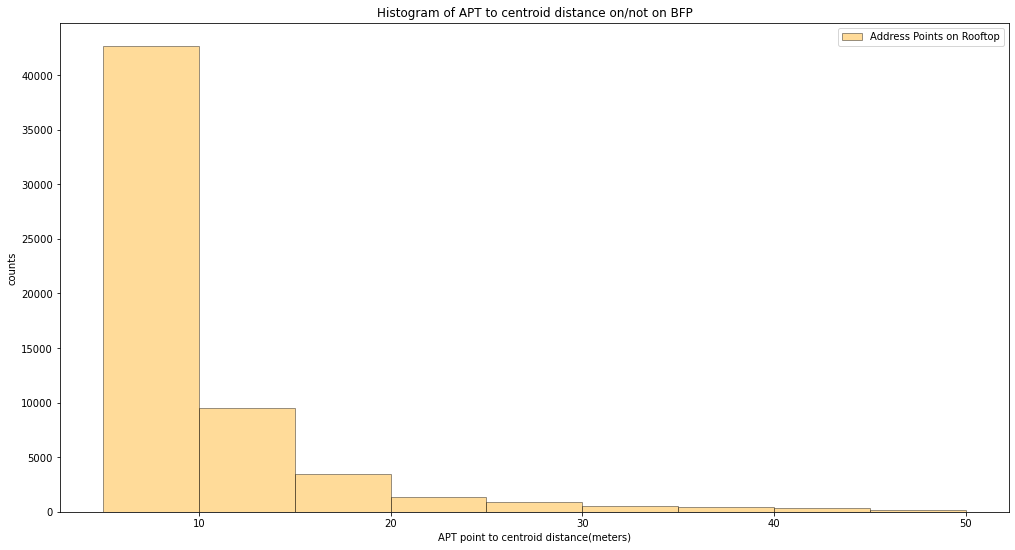

311

In [24]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(final_output['APT_to_Centroid_distance'].loc[final_output['APT_to_Centroid_distance']<50].values, bins = np.arange(5,55,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

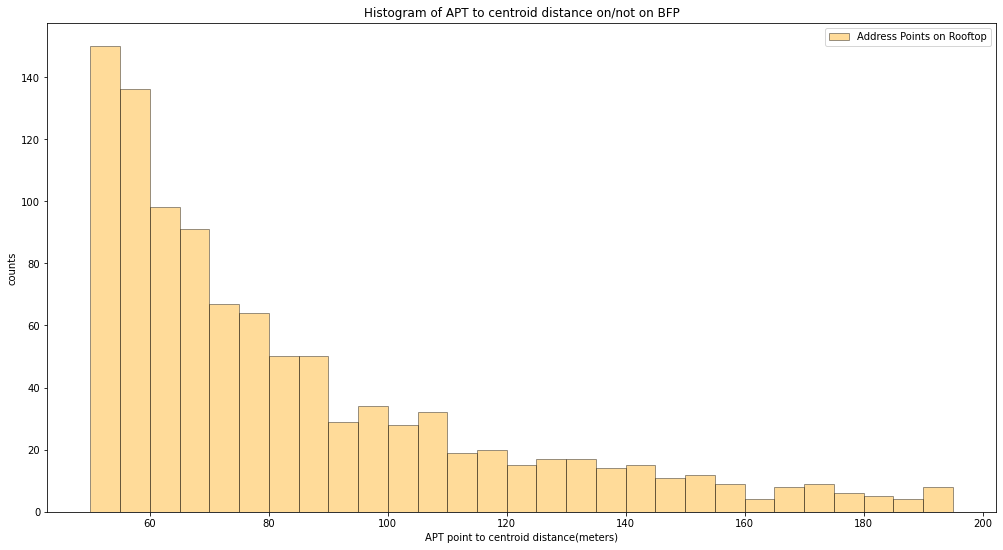

3655

In [25]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(final_output['APT_to_Centroid_distance'].loc[final_output['APT_to_Centroid_distance']>50].values, bins = np.arange(50,200,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [30]:
# df_for_analysis_usa_ca_santa_clara = processed_df.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
# df_for_analysis_usa_ca_santa_clara.head()

,updated_geometries,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
12,POINT (-121.90984 37.46259),00005543-3300-2800-0000-0000006538d8,Latn,ENG,95035,163,CA,Milpitas,Buskirk St,USA,None,St,None,None,Buskirk,14.1,37.462511,-121.909722,37.462594,-121.909845
12,POINT (-121.90966 37.46267),00005543-3300-2800-0000-0000006538d8,Latn,ENG,95035,163,CA,Milpitas,Buskirk St,USA,None,St,None,None,Buskirk,17.9,37.462511,-121.909722,37.462665,-121.909660
21,POINT (-122.12595 37.43630),00005543-3300-2800-0000-00000064c961,Latn,ENG,94303,2671,CA,Palo Alto,Marshall Dr,USA,None,Dr,None,None,Marshall,1.6,37.436287,-122.125943,37.436300,-122.125952
21,POINT (-122.12571 37.43636),00005543-3300-2800-0000-00000064c961,Latn,ENG,94303,2671,CA,Palo Alto,Marshall Dr,USA,None,Dr,None,None,Marshall,21.9,37.436287,-122.125943,37.436355,-122.125710
29,POINT (-122.12523 37.43718),00005543-3300-2800-0000-00000064e166,Latn,ENG,94303,855,CA,Palo Alto,Bruce Dr,USA,None,Dr,None,None,Bruce,4.7,37.437213,-122.125261,37.437177,-122.125232


In [31]:
output_path = os.path.join(data_path,state,city,'Apt_realignment_parcel_to_2bfp')
if not os.path.isdir(output_path):
    os.makedirs(output_path)
print(output_path)

filename = os.path.join(output_path,'APT_realigned_usa_uca_SC')
geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_ca_santa_clara, geometry='updated_geometries', crs="EPSG:4326")
pd_dataframe = pd.DataFrame(geo_dataframe)

pd_dataframe.to_pickle(filename+'.pkl')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename+'.shp')

/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/California/SantaClara/Apt_realignment_parcel_to_2bfp


In [32]:
def save_geometry(dataframe,geometry,out_path,fname='dataframe.geojson'):
    df_to_save = gpd.GeoDataFrame(geometry=dataframe[geometry],crs="EPSG:4326")
    df_to_save = df_to_save.to_crs("epsg:4326")
    df_to_save.to_file(os.path.join(out_path,fname),driver="GeoJSON")

out_path = output_path = os.path.join(data_path,state,city)
filename = os.path.join(out_path,'APT_realigned_usa_uca_SC_buidling_roi.geojson')
save_geometry(processed_df,'building_roi',out_path=out_path,fname=filename)

## Araphoe Colarado  

In [1]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment/utils')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.extract_mnr_data import ExtractMNRData as extract_mnr_data

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Colorado"
city = "Arapahoe"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_010_nam_usa_uco.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_08005/Parcels_08005.shp")
building_geojson = os.path.join(data_path,state,'Colorado.geojson')

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [20]:
# mnr_database = extract_mnr_data(country_code='_2022_06_012_nam_usa_uco')
# mnr_database.connect_to_server()
# out_path = os.path.join(data_path,state)
# mnr_apt_df = mnr_database.extract_apt_addresses_data()
# mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_012_nam_usa_uco.shp')

2022-08-16 11:55:51,266:INFO:- Data base Connection Successful
2022-08-16 11:55:58,040:INFO:- Running SQL query on _2022_06_012_nam_usa_uco schema
2022-08-16 12:00:49,522:INFO:- APT Data Downloaded Took 4.86 min


'/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Colorado/APT_2022_06_012_nam_usa_uco.shp'

In [2]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df = apt_preprocess.process_dataframe(bfp_count_per_parcel=2)
processed_df.head(10)

2022-08-16 09:44:30,676:INFO:- Creating Realignment-matrix for APT's
2022-08-16 09:44:30,678:INFO:- Processing Land Parcel data and Building Footprints 
2022-08-16 09:47:03,206:INFO:- Generating Parcel BFP matrix for 2 BFP within Parcel
2022-08-16 09:47:03,478:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe


,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT
8,1971-35-3-21-029,08005,100660192_205096955,"POLYGON ((-104.97597 39.65503, -104.97641 39.6...","POLYGON ((-104.976277 39.655142, -104.976397 3...","POLYGON ((-104.97628 39.65514, -104.97640 39.6...",POINT (-104.97634 39.65511),00004358-3100-2800-0000-00000003f05d,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9761296 39.6552102)
8,1971-35-3-21-029,08005,100660192_205096955,"POLYGON ((-104.97597 39.65503, -104.97641 39.6...","POLYGON ((-104.976202 39.655158, -104.976074 3...","POLYGON ((-104.97620 39.65516, -104.97607 39.6...",POINT (-104.97615 39.65522),00004358-3100-2800-0000-00000003f05d,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9761296 39.6552102)
9,1971-35-3-20-007,08005,100660192_205096947,"POLYGON ((-104.97531 39.65553, -104.97576 39.6...","POLYGON ((-104.975398 39.655621, -104.975486 3...","POLYGON ((-104.97540 39.65562, -104.97549 39.6...",POINT (-104.97544 39.65558),00004358-3100-2800-0000-00000003f0ce,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9756025 39.6556331)
9,1971-35-3-20-007,08005,100660192_205096947,"POLYGON ((-104.97531 39.65553, -104.97576 39.6...","POLYGON ((-104.975571 39.655696, -104.975681 3...","POLYGON ((-104.97557 39.65570, -104.97568 39.6...",POINT (-104.97562 39.65564),00004358-3100-2800-0000-00000003f0ce,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9756025 39.6556331)
10,1971-35-3-20-006,08005,100660192_205096946,"POLYGON ((-104.97530 39.65570, -104.97576 39.6...","POLYGON ((-104.975571 39.655696, -104.975681 3...","POLYGON ((-104.97557 39.65570, -104.97568 39.6...",POINT (-104.97562 39.65564),00004358-3100-2800-0000-00000003f0cf,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9756053 39.6557731)
10,1971-35-3-20-006,08005,100660192_205096946,"POLYGON ((-104.97530 39.65570, -104.97576 39.6...","POLYGON ((-104.975564 39.65572, -104.975567 39...","POLYGON ((-104.97556 39.65572, -104.97557 39.6...",POINT (-104.97562 39.65578),00004358-3100-2800-0000-00000003f0cf,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9756053 39.6557731)
19,1971-35-3-20-012,08005,100660192_205096959,"POLYGON ((-104.97481 39.65519, -104.97525 39.6...","POLYGON ((-104.975095 39.655047, -104.975 39.6...","POLYGON ((-104.97509 39.65505, -104.97500 39.6...",POINT (-104.97500 39.65512),00004358-3100-2800-0000-00000003f0cc,Latn,ENG,...,CO,Englewood,S Corona St,USA,None,St,S,None,Corona,POINT (-104.975018 39.655273)
19,1971-35-3-20-012,08005,100660192_205096959,"POLYGON ((-104.97481 39.65519, -104.97525 39.6...","POLYGON ((-104.975032 39.655207, -104.974922 3...","POLYGON ((-104.97503 39.65521, -104.97492 39.6...",POINT (-104.97498 39.65528),00004358-3100-2800-0000-00000003f0cc,Latn,ENG,...,CO,Englewood,S Corona St,USA,None,St,S,None,Corona,POINT (-104.975018 39.655273)
20,1971-35-3-20-010,08005,100660192_205096958,"POLYGON ((-104.97531 39.65503, -104.97576 39.6...","POLYGON ((-104.975329 39.655068, -104.975327 3...","POLYGON ((-104.97533 39.65507, -104.97533 39.6...",POINT (-104.97538 39.65510),00004358-3100-2800-0000-00000003f0c8,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9755902 39.6551412)
20,1971-35-3-20-010,08005,100660192_205096958,"POLYGON ((-104.97531 39.65503, -104.97576 39.6...","POLYGON ((-104.975678 39.655092, -104.975571 3...","POLYGON ((-104.97568 39.65509, -104.97557 39.6...",POINT (-104.97560 39.65515),00004358-3100-2800-0000-00000003f0c8,Latn,ENG,...,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,POINT (-104.9755902 39.6551412)


In [3]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df['APT_to_Centroid_distance'] = processed_df.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df['APT_lat'] = processed_df['APT'].apply(lambda z: z.y)
processed_df['APT_lon'] = processed_df['APT'].apply(lambda z: z.x)

processed_df['updated_lat'] = processed_df['updated_geometries'].apply(lambda z: z.y)
processed_df['updated_lon'] = processed_df['updated_geometries'].apply(lambda z: z.x)
processed_df.head()

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
8,1971-35-3-21-029,08005,100660192_205096955,"POLYGON ((-104.97597 39.65503, -104.97641 39.6...","POLYGON ((-104.976277 39.655142, -104.976397 3...","POLYGON ((-104.97628 39.65514, -104.97640 39.6...",POINT (-104.97634 39.65511),00004358-3100-2800-0000-00000003f05d,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9761296 39.6552102),21.1,39.655210,-104.976130,39.655106,-104.976336
8,1971-35-3-21-029,08005,100660192_205096955,"POLYGON ((-104.97597 39.65503, -104.97641 39.6...","POLYGON ((-104.976202 39.655158, -104.976074 3...","POLYGON ((-104.97620 39.65516, -104.97607 39.6...",POINT (-104.97615 39.65522),00004358-3100-2800-0000-00000003f05d,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9761296 39.6552102),1.7,39.655210,-104.976130,39.655221,-104.976146
9,1971-35-3-20-007,08005,100660192_205096947,"POLYGON ((-104.97531 39.65553, -104.97576 39.6...","POLYGON ((-104.975398 39.655621, -104.975486 3...","POLYGON ((-104.97540 39.65562, -104.97549 39.6...",POINT (-104.97544 39.65558),00004358-3100-2800-0000-00000003f0ce,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9756025 39.6556331),14.7,39.655633,-104.975602,39.655584,-104.975443
9,1971-35-3-20-007,08005,100660192_205096947,"POLYGON ((-104.97531 39.65553, -104.97576 39.6...","POLYGON ((-104.975571 39.655696, -104.975681 3...","POLYGON ((-104.97557 39.65570, -104.97568 39.6...",POINT (-104.97562 39.65564),00004358-3100-2800-0000-00000003f0ce,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9756025 39.6556331),1.1,39.655633,-104.975602,39.655635,-104.975615
10,1971-35-3-20-006,08005,100660192_205096946,"POLYGON ((-104.97530 39.65570, -104.97576 39.6...","POLYGON ((-104.975571 39.655696, -104.975681 3...","POLYGON ((-104.97557 39.65570, -104.97568 39.6...",POINT (-104.97562 39.65564),00004358-3100-2800-0000-00000003f0cf,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9756053 39.6557731),15.3,39.655773,-104.975605,39.655635,-104.975615


In [19]:
building_within_parcel_count = processed_df.groupby('PRCLDMPID').count()['geometry']
parcel_ids_with_one_building = list(building_within_parcel_count[building_within_parcel_count == 2].keys())
filtered_dataframe = processed_df[processed_df['PRCLDMPID'].isin(parcel_ids_with_one_building)]
filtered_dataframe

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,updated_geometries,feat_id,iso_script,iso_lang_c,...,suffix,predir,postdir,sn_body,APT,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
8,1971-35-3-21-029,08005,100660192_205096955,"POLYGON ((-104.97597 39.65503, -104.97641 39.6...","POLYGON ((-104.976277 39.655142, -104.976397 3...","POLYGON ((-104.97628 39.65514, -104.97640 39.6...",POINT (-104.97634 39.65511),00004358-3100-2800-0000-00000003f05d,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9761296 39.6552102),21.1,39.655210,-104.976130,39.655106,-104.976336
8,1971-35-3-21-029,08005,100660192_205096955,"POLYGON ((-104.97597 39.65503, -104.97641 39.6...","POLYGON ((-104.976202 39.655158, -104.976074 3...","POLYGON ((-104.97620 39.65516, -104.97607 39.6...",POINT (-104.97615 39.65522),00004358-3100-2800-0000-00000003f05d,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9761296 39.6552102),1.7,39.655210,-104.976130,39.655221,-104.976146
9,1971-35-3-20-007,08005,100660192_205096947,"POLYGON ((-104.97531 39.65553, -104.97576 39.6...","POLYGON ((-104.975398 39.655621, -104.975486 3...","POLYGON ((-104.97540 39.65562, -104.97549 39.6...",POINT (-104.97544 39.65558),00004358-3100-2800-0000-00000003f0ce,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9756025 39.6556331),14.7,39.655633,-104.975602,39.655584,-104.975443
9,1971-35-3-20-007,08005,100660192_205096947,"POLYGON ((-104.97531 39.65553, -104.97576 39.6...","POLYGON ((-104.975571 39.655696, -104.975681 3...","POLYGON ((-104.97557 39.65570, -104.97568 39.6...",POINT (-104.97562 39.65564),00004358-3100-2800-0000-00000003f0ce,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9756025 39.6556331),1.1,39.655633,-104.975602,39.655635,-104.975615
10,1971-35-3-20-006,08005,100660192_205096946,"POLYGON ((-104.97530 39.65570, -104.97576 39.6...","POLYGON ((-104.975571 39.655696, -104.975681 3...","POLYGON ((-104.97557 39.65570, -104.97568 39.6...",POINT (-104.97562 39.65564),00004358-3100-2800-0000-00000003f0cf,Latn,ENG,...,St,S,None,Ogden,POINT (-104.9756053 39.6557731),15.3,39.655773,-104.975605,39.655635,-104.975615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214357,2071-28-2-25-002,08005,100660192_205292337,"POLYGON ((-104.67785 39.59253, -104.67791 39.5...","POLYGON ((-104.677878 39.592736, -104.677994 3...","POLYGON ((-104.67788 39.59274, -104.67799 39.5...",POINT (-104.67799 39.59269),00004358-3100-2800-0000-000000217b52,Latn,ENG,...,Way,S,None,Quantock,POINT (-104.677944 39.592691),3.5,39.592691,-104.677944,39.592695,-104.677985
214377,2071-28-2-24-026,08005,100660192_205292352,"POLYGON ((-104.67816 39.59078, -104.67875 39.5...","POLYGON ((-104.678358 39.590814, -104.678352 3...","POLYGON ((-104.67836 39.59081, -104.67835 39.5...",POINT (-104.67844 39.59088),00004358-3100-2800-0000-000000217b5c,Latn,ENG,...,Way,S,None,Riverwood,POINT (-104.6784404 39.5908701),1.1,39.590870,-104.678440,39.590880,-104.678442
214377,2071-28-2-24-026,08005,100660192_205292352,"POLYGON ((-104.67816 39.59078, -104.67875 39.5...","POLYGON ((-104.67827 39.590859, -104.678266 39...","POLYGON ((-104.67827 39.59086, -104.67827 39.5...",POINT (-104.67829 39.59089),00004358-3100-2800-0000-000000217b5c,Latn,ENG,...,Way,S,None,Riverwood,POINT (-104.6784404 39.5908701),12.8,39.590870,-104.678440,39.590893,-104.678293
214385,2071-28-2-24-018,08005,100660192_205292343,"POLYGON ((-104.67807 39.59177, -104.67810 39.5...","POLYGON ((-104.677886 39.591767, -104.677857 3...","POLYGON ((-104.67789 39.59177, -104.67786 39.5...",POINT (-104.67793 39.59186),00004358-3100-2800-0000-000000217b64,Latn,ENG,...,Pl,E,None,Costilla,POINT (-104.678091 39.5919296),15.8,39.591930,-104.678091,39.591864,-104.677927


In [4]:
distance_greater_than_50m = processed_df.loc[processed_df['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df.shape[0])))

Max distance APT from Parcel to Building Centroid 901.80 m
Data points greater than 50m: 5.46% 


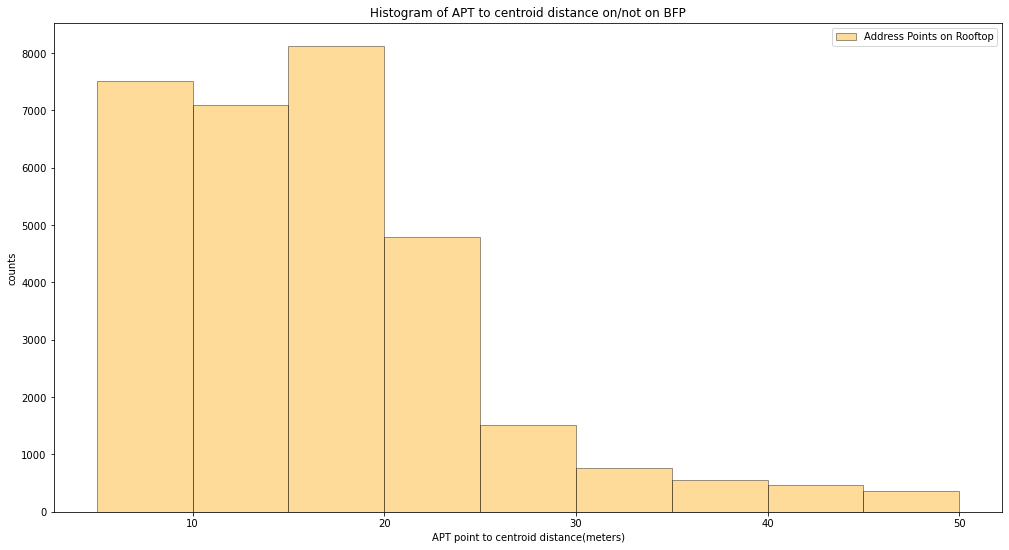

6

In [5]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']<50].values, bins = np.arange(5,55,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

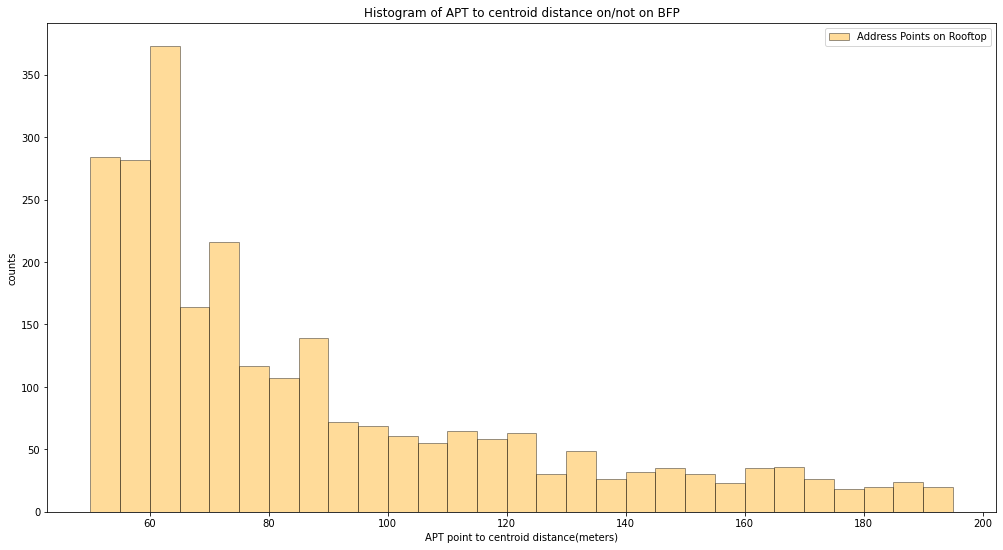

3655

In [6]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df['APT_to_Centroid_distance'].loc[processed_df['APT_to_Centroid_distance']>50].values, bins = np.arange(50,200,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [9]:
df_for_analysis_usa_co_Araphoe = processed_df.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_co_Araphoe.head()

,updated_geometries,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT_to_Centroid_distance,APT_lat,APT_lon,updated_lat,updated_lon
8,POINT (-104.97634 39.65511),00004358-3100-2800-0000-00000003f05d,Latn,ENG,80113,3383,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,21.1,39.655210,-104.976130,39.655106,-104.976336
8,POINT (-104.97615 39.65522),00004358-3100-2800-0000-00000003f05d,Latn,ENG,80113,3383,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,1.7,39.655210,-104.976130,39.655221,-104.976146
9,POINT (-104.97544 39.65558),00004358-3100-2800-0000-00000003f0ce,Latn,ENG,80113,3360,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,14.7,39.655633,-104.975602,39.655584,-104.975443
9,POINT (-104.97562 39.65564),00004358-3100-2800-0000-00000003f0ce,Latn,ENG,80113,3360,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,1.1,39.655633,-104.975602,39.655635,-104.975615
10,POINT (-104.97562 39.65564),00004358-3100-2800-0000-00000003f0cf,Latn,ENG,80113,3356,CO,Englewood,S Ogden St,USA,None,St,S,None,Ogden,15.3,39.655773,-104.975605,39.655635,-104.975615


In [10]:
output_path = os.path.join(data_path,state,city,'Apt_realignment_parcel2bfp_one2two_map')
if not os.path.isdir(output_path):
    os.makedirs(output_path)
print(output_path)

filename = os.path.join(output_path,'APT_realigned_usa_uca_SC')
geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_co_Araphoe, geometry='updated_geometries', crs="EPSG:4326")
pd_dataframe = pd.DataFrame(geo_dataframe)

pd_dataframe.to_pickle(filename+'.pkl')
geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename+'.shp')

/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Colorado/Arapahoe/Apt_realignment_parcel2bfp_one2two_map


In [11]:
def save_geometry(dataframe,geometry,out_path,fname='dataframe.geojson'):
    df_to_save = gpd.GeoDataFrame(geometry=dataframe[geometry],crs="EPSG:4326")
    df_to_save = df_to_save.to_crs("epsg:4326")
    df_to_save.to_file(os.path.join(out_path,fname),driver="GeoJSON")

out_path = output_path = os.path.join(data_path,state,city)
filename = os.path.join(out_path,'APT_realigned_usa_uco_apaphoe_bfp.geojson')
save_geometry(processed_df,'building_roi',out_path=out_path,fname=filename)

## Miami Dade Florida 

In [21]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment/utils')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.extract_mnr_data import ExtractMNRData as extract_mnr_data

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Florida"
city = "Miamidade"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_010_nam_usa_ufl.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_08005/Parcels_08005.shp")
building_geojson = os.path.join(data_path,state,'Florida.geojson')

In [22]:
mnr_database = extract_mnr_data(country_code='_2022_06_012_nam_usa_ufl')
mnr_database.connect_to_server()
out_path = os.path.join(data_path,state)
mnr_apt_df = mnr_database.extract_apt_addresses_data()
mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_012_nam_usa_ufl.shp')

2022-08-16 13:32:27,467:INFO:- Data base Connection Successful
2022-08-16 13:32:34,686:INFO:- Running SQL query on _2022_06_012_nam_usa_ufl schema
2022-08-16 13:47:51,747:INFO:- APT Data Downloaded Took 15.28 min


'/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Florida/APT_2022_06_012_nam_usa_ufl.shp'